In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import trange
import pickle

In [ ]:
# fix the loss calculation in trainer

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

device = torch.device('cpu')

In [5]:
class BayesianNetwork(nn.Module):
    def __init__(self, margin:int=3, positional:bool=True,num_layer:int=1, activation:str='relu' ):
        super().__init__()
        self.margin = margin
        self.po = positional
        self.num_layer = num_layer
        self.find_input_dim()
        self.activation = activation

        self.model = self.select_model()



        
        if self.num_layer not in [1,2]:
            raise ValueError('Only networks with one or two layers are valid')
    
    def forward(self, x):
        x = self.model(x)
        return x

    def select_model(self):
        
        if self.num_layer == 1:
            return self.one_layer_net()
        elif self.num_layer == 2:
            return self.two_layer_net()

    
    def one_layer_net(self):
        model = nn.Sequential(
                nn.Linear(self.input_dim, 1),
                nn.Sigmoid()
        )
        return model
    
    def two_layer_net(self):
        model = nn.Sequential(
                nn.Linear(self.input_dim, 40),
                self.select_activation(),
                nn.Linear(40, 1),
                nn.Sigmoid()
        )
        return model
    
    def select_activation(self):
        if self.activation == 'relu':
            return nn.ReLU()
        elif self.activation == 'silu':
            return nn.SiLU()
        elif self.activation not in ['relu', 'silu']:
            raise ValueError('Only relu and silu activation function are valid')

    def find_input_dim(self):
        if self.po:
            self.input_dim = (self.margin+1)**2 + 1
        elif not self.po:
            self.input_dim = (self.margin+1)**2 - 1

    def sample(self,test_im):
        blank = np.zeros(shape=(test_im.shape[0]+self.margin, test_im.shape[1]+self.margin))
        idx = np.arange(self.margin,blank.shape[0])
        for i in idx:
            for j in idx:
                x,_ = xy_of_image(
                    test_im.shape[0],
                    blank,
                    i, 
                    j, 
                    self.margin,
                    self.po
                )
                x_tensor,_ = model_input(x,x)
                y_hat = self(x_tensor)
                blank[i, j] = y_hat.cpu().detach().numpy()
        return blank

class SingleNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predictions, targets):
        predictions = torch.clamp(predictions, min=1e-7, max=1-1e-7)
        loss = -torch.mean(targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions))
        return loss


In [17]:
import imageio.v2 as imageio

def xy_of_image(im_size:int, image:np.ndarray, i:int, j:int, margin:int=1, positional:bool=True ) -> tuple[np.ndarray, np.ndarray]:
    '''Extract X (parents) of a pixel (y)'''
    x = image[i-margin:i+1, j-margin:j+1].flatten()
    y = x[-1]
    x = x[:-1]
    if positional:
        ax_y = (i-margin)/im_size
        ax_x = (j-margin)/im_size            
        x = np.append(x, [ax_x, ax_y])
    return x,y


def image_to_xy(path:str, margin:int=3, positional:bool=True) -> tuple[np.ndarray, np.ndarray]:
    '''Turns an image into training data (path -> read image -> X, y matrices)'''
    image = imageio.imread(path) 

    X, Y = image2xy(image, margin, positional)

    return X, Y

def image2xy(image:np.ndarray, margin:int=3, positional:bool=True, return_blank:bool=False) -> tuple[np.ndarray, np.ndarray]:
    '''Turns an image into training data (image -> X, y matrices)'''
    shape_im = image.shape
    new_im = np.zeros(shape=(shape_im[0]+margin, shape_im[1]+margin))
    new_im[margin:, margin:] = image

    idx = np.arange(margin,new_im.shape[0])
    idx_size = idx.shape[0]

    X_list = []
    y_list = []

    for i in idx:
        for j in idx:
            x, y = xy_of_image(idx_size, new_im, i, j, margin, positional)
            X_list.append(x)
            y_list.append(y)

    X = np.array(X_list)
    Y = np.array(y_list)
    if not return_blank:
        return X,Y
    else:
        return X, Y, new_im


def create_dataset(f_names:list, f_label:list, margin:int=1, positional:bool=True) -> tuple[np.ndarray, np.ndarray]:
    '''Create dataset for given image paths'''
    X = np.zeros(shape=(len(f_label)*400, (margin+1)**2+1 if positional else (margin+1)**2 -1))
    Y = np.zeros(shape=(len(f_label)*400,))

    for i in trange(len(f_label)):
        f_dir = os.path.join(small_dir, f_label[i], f_names[i])
        x, y = image_to_xy(f_dir, margin, positional)
        X[i*400:(i+1)*400,:] = x
        Y[i*400:(i+1)*400] = y
    return X, Y

def train_model(model, train_loader, val_loader=None, n_jobs=None, epochs=5, device=device):

    model.model.to(device)
    if n_jobs:
        torch.set_num_threads(n_jobs)  # Set number of threads to be used

    # Use CrossEntropyLoss for classification tasks
    criterion = SingleNLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss_list = []
    train_iteration_loss_list = []
    val_loss_list = []

    try:
        for epoch in range(epochs):
            model.train()
            train_loss = 0

            # Train loop
            pbar = trange(len(train_loader), desc=f'Epoch {epoch+1}/{epochs}')
            train_iter = iter(train_loader)
            for i in pbar:
                X_batch, y_batch = next(train_iter)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_hat = model(X_batch)
                loss = criterion(y_batch_hat, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                t_loss = loss.item()
                t_loss /= len(y_batch)
                train_iteration_loss_list.append(t_loss)
                pbar.set_postfix_str(f'train loss: {sum(train_iteration_loss_list) / (i + 1):.4f}')

            t_loss /= len(train_loader)
            train_loss_list.append(t_loss)

            if val_loader:
                # Validation loop
                model.eval()
                with torch.no_grad():
                    v_loss = 0
                    val_iter = iter(val_loader)
                    for _ in val_iter:
                        X_val, y_val = next(val_iter)
                        X_val = X_val.to(device)
                        y_val = y_val.to(device)

                        y_val_hat = model(X_val)
                        loss = criterion(y_val_hat, y_val)
                        v_loss += loss.item()

                    val_loss_list.append(v_loss / len(val_loader))
                print(f'Validation Loss: {val_loss_list[-1]:.4f}')

            # generate image
            gen_im = model.sample(np.zeros(shape=(20,20)))
            plt.figure()
            plt.imshow(gen_im)
            plt.title('Generated image')
            plt.show()

        return train_loss_list, val_loss_list, train_iteration_loss_list

    except KeyboardInterrupt:
        print('\n\n!!!!!!!! Training has been stopped !!!!!!!!')
        return train_loss_list, val_loss_list, train_iteration_loss_list


def model_input(x=None, y=None):
    '''Prepare data for model'''
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y/255, dtype=torch.long)
    return x_tensor, y_tensor

## Work with data

In [7]:
small_dir = r'Data\small'
mid_dir = r'Data\mid'
big_dir = r'Data\big'

s_folders = os.listdir(small_dir)
m_folders = os.listdir(mid_dir)
b_folders = os.listdir(big_dir)

Read all file names

In [8]:
f_names = []
f_label = []

for root, dirs, files in os.walk(small_dir):

    if len(root.split("\\")) == 3:
        label = root.split('\\')[-1]
        for f in files:
            f_names.append(f)
            f_label.append(label)


splitting the data into train, validation and test

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
f_train, f_test, l_train, l_test = train_test_split(
    f_names,
    f_label,
    test_size = 0.1,
    shuffle = True,
    random_state = 69
)

f_train, f_val, l_train, l_val = train_test_split(
    f_train,
    l_train,
    test_size = 0.111,
    shuffle = True,
    random_state = 69
)

Read images to create trainnig data

In [11]:
MARGIN = 1
POSITIONAL = True

# print('Create Train dataset')
# X_train, y_train = create_dataset(f_train, l_train, MARGIN, POSITIONAL)
print('Create Validation dataset')
X_val, y_val = create_dataset(f_val, l_val, MARGIN, POSITIONAL)
X_train, y_train = X_val.copy(), y_val.copy()

Create Validation dataset


100%|██████████| 1305/1305 [00:20<00:00, 65.17it/s] 


In [12]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [13]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f) 

# with open("scaler.pkl", "rb") as f:
#     loaded_scaler = pickle.load(f)

In [14]:
# train_tensor = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_tensor, batch_size=256, shuffle=True)
# val_tensor = TensorDataset(X_val, y_val)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val/255, dtype=torch.long)
X_val_tensor, y_val_tensor = model_input(X_val, y_val)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_tensor, shuffle=False, batch_size=2**14)
train_loader = DataLoader(val_tensor, batch_size=2048, shuffle=True)

## Model

In [40]:
ACTIVATION = 'relu'

single_layer_model = BayesianNetwork(1, True, num_layer=1).to(device)    
double_layer_model = BayesianNetwork(1, True, num_layer=2, activation=ACTIVATION).to(device)
random_weights = single_layer_model.state_dict()['model.0.weight'].cpu().detach().numpy()

[[ 0.19181561  0.20017588  0.42278808 -0.0455893  -0.08717257]]


C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_13700\1757037348.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = y_hat.cpu().detach().numpy()


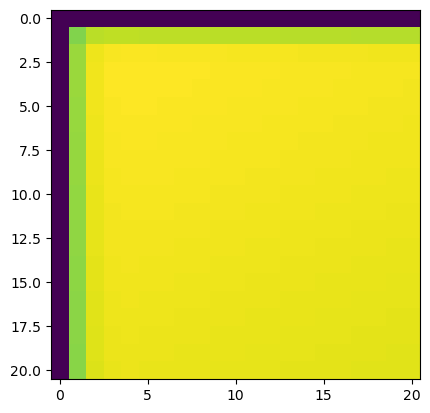

Epoch 1/2: 100%|██████████| 255/255 [00:09<00:00, 26.42it/s, train loss: 0.0011]


Validation Loss: 1.0481


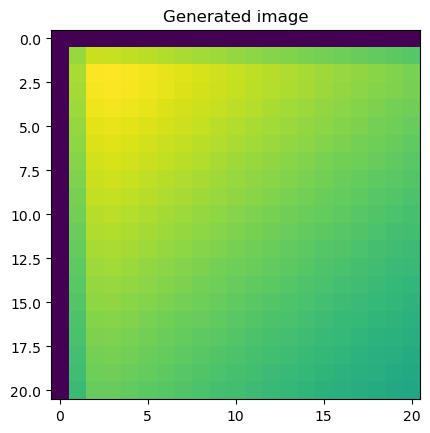

Epoch 2/2: 100%|██████████| 255/255 [00:09<00:00, 27.27it/s, train loss: 0.0021]


Validation Loss: 1.0137


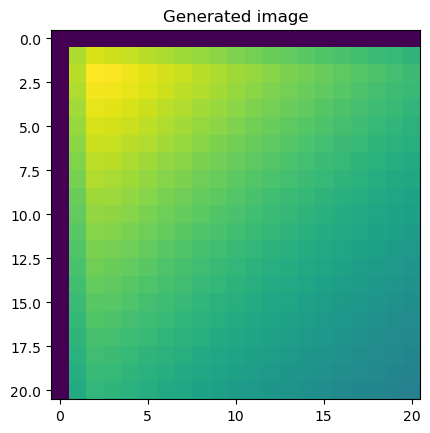

[[ 0.19181561  0.20017588  0.42278808 -0.5084804  -0.54893225]]


In [42]:
print( single_layer_model.state_dict()['model.0.weight'].cpu().detach().numpy())
plt.figure()
plt.imshow(single_layer_model.sample(np.zeros(shape=(20,20))))
plt.show()
history = train_model(single_layer_model, train_loader, val_loader, epochs=2)
print (single_layer_model.state_dict()['model.0.weight'].cpu().detach().numpy())

In [31]:
print(random_weights)
print(pw)
print(ow)

[[ 0.19935215 -0.41492853 -0.3528837  -0.38077888 -0.33583105]]
[[ 0.19935215 -0.41492853 -0.3528837  -0.38077888 -0.33583105]]
[[ 0.19935215 -0.41492853 -0.3528837  -0.38077888 -0.33583105]]


[[-0.3886811  -0.29149735  0.39299655 -0.4281664  -0.262541  ]
 [ 0.21847165 -0.01863155 -0.05706859 -0.40671566  0.30938554]
 [ 0.33391684  0.12099934  0.22853929 -0.41558906  0.07466239]
 [-0.12385789  0.31237382  0.08668828 -0.01442453  0.15208769]
 [ 0.0280731   0.08618283 -0.04881024 -0.3335593  -0.35042876]
 [-0.19169652  0.19323373 -0.10027483  0.29101986  0.22889543]
 [ 0.43633765 -0.13418788  0.02617696  0.08604193 -0.29778567]
 [ 0.40671712  0.4089347   0.00946411 -0.0736669   0.16758937]
 [ 0.40984797  0.07688171  0.2528146   0.16864038  0.06278026]
 [-0.3478979  -0.27799028  0.00338131 -0.35035583  0.01078647]
 [-0.01336789  0.13711894 -0.2526074   0.32224566 -0.33331332]
 [ 0.40594685 -0.36566636  0.11655009  0.32674682  0.06113559]
 [-0.3452462   0.07696503  0.17573708 -0.32036394 -0.34066105]
 [-0.08150768 -0.12384105  0.44232428 -0.04796785 -0.22977254]
 [-0.32105508  0.29614013  0.24100584 -0.17010894  0.2145108 ]
 [ 0.274714   -0.43319172  0.30829412 -0.00789624 -0.10

C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_13700\1757037348.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = y_hat.cpu().detach().numpy()


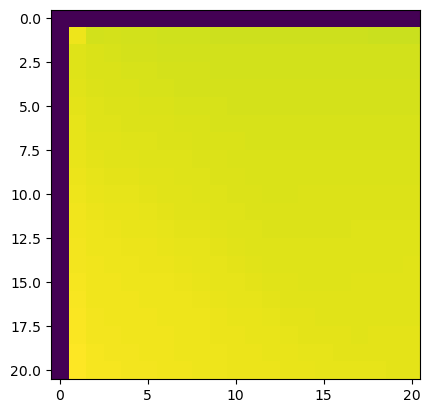

Epoch 1/2: 100%|██████████| 255/255 [00:09<00:00, 26.39it/s, train loss: 0.0002]


Validation Loss: 0.2074


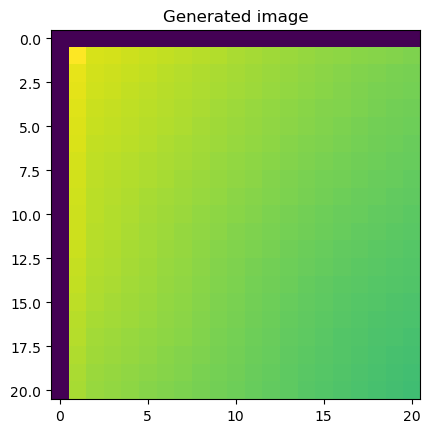

Epoch 2/2: 100%|██████████| 255/255 [00:09<00:00, 25.79it/s, train loss: 0.0004]


Validation Loss: 0.1981


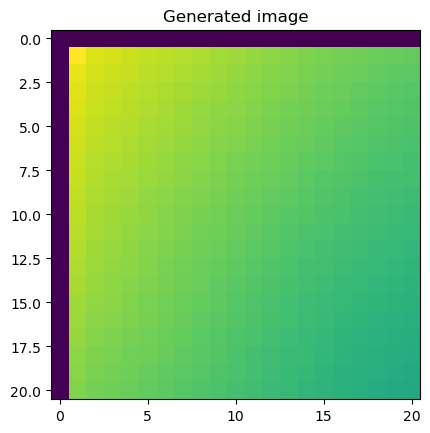

[[-0.38785294 -0.29149735  0.39382473 -0.42535803 -0.25828648]
 [ 0.18545508 -0.01704147 -0.05328078 -0.3682733   0.34927416]
 [ 0.34055337  0.11658857  0.22585414 -0.42103496  0.06570479]
 [-0.12173156  0.31846386  0.08668828 -0.00186969  0.17453916]
 [ 0.03387865  0.08451505 -0.04881024 -0.33355722 -0.3504273 ]
 [-0.19462435  0.18541539 -0.10027483  0.2755653   0.21303178]
 [ 0.42735165 -0.13269413  0.02978282  0.08620708 -0.29780853]
 [ 0.3885851   0.40702564  0.00962528 -0.05716998  0.18470825]
 [ 0.4074432   0.07791736  0.2542844   0.16863513  0.06277532]
 [-0.3478979  -0.27799028  0.00338131 -0.35035583  0.01078647]
 [-0.01509692  0.13208468 -0.2526074   0.31993625 -0.33354294]
 [ 0.39538696 -0.36727506  0.11305271  0.3289014   0.06346615]
 [-0.3452462   0.07347582  0.17573708 -0.32037032 -0.34066904]
 [-0.07555451 -0.12384105  0.44827744 -0.04795491 -0.22975913]
 [-0.32105508  0.2947672   0.24100584 -0.17011145  0.21450764]
 [ 0.24866463 -0.43319172  0.30894572  0.01754476 -0.07

In [41]:
print( double_layer_model.state_dict()['model.0.weight'].cpu().detach().numpy())
plt.figure()
plt.imshow(double_layer_model.sample(np.zeros(shape=(20,20))))
plt.show()
history = train_model(double_layer_model, train_loader, val_loader, epochs=2)
print (double_layer_model.state_dict()['model.0.weight'].cpu().detach().numpy())

# torch.save(double_layer_model.state_dict(), 'model_weights.pth')

In [35]:
pw2 == ow2

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  Tr

In [90]:
primory_weights['layer1.weight'] == output_weights['layer1.weight']

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],


In [63]:
single_layer_model.load_state_dict(
    torch.load('model_weights.pth', map_location='cpu')   
)

<All keys matched successfully>

In [125]:
a = single_layer_model.sample(test_im)

C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_12632\1757037348.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = y_hat.cpu().detach().numpy()


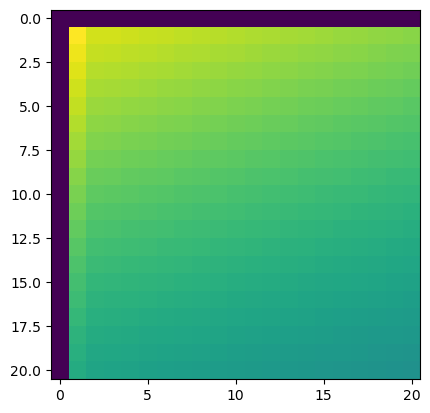

In [126]:
plt.imshow(a)

## Junk code

In [ ]:
im_size = 20
MARGIN = 1
single_layer_model.eval()

test_X, test_y, big_im = image2xy(test_im, MARGIN, POSITIONAL, True)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)

for i in range(test_X.shape[0]):
    test_X, test_y, big_im = image2xy(test_im, MARGIN, POSITIONAL, True)
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
    test_x_tensor = test_X_tensor[i,:]
    with torch.no_grad():
        test_output = single_layer_model(test_x_tensor)
    

In [ ]:
out_im = test_output

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0

In [19]:
import imageio

C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_12632\4043898666.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_im = imageio.imread(test_dir)


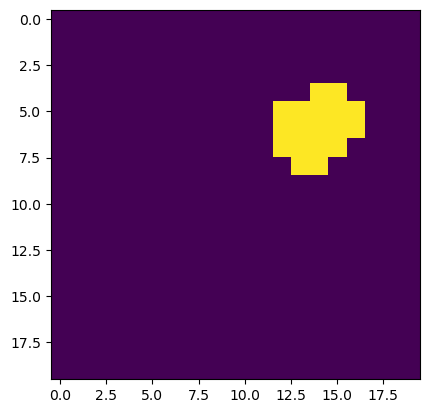

In [20]:
test_dir = os.path.join(small_dir, l_train[50],f_train[50])
test_im = imageio.imread(test_dir)
plt.imshow(test_im)

the shape of the image is (20, 20)
the shape of the blank is (21, 21)


C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_12632\3105447353.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  blank[i, j] = y_hat.cpu().detach().numpy()


Text(0.5, 1.0, 'Sample')

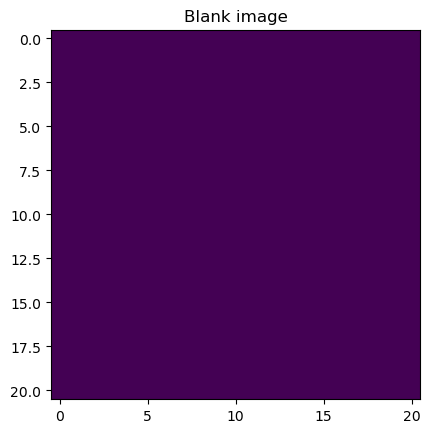

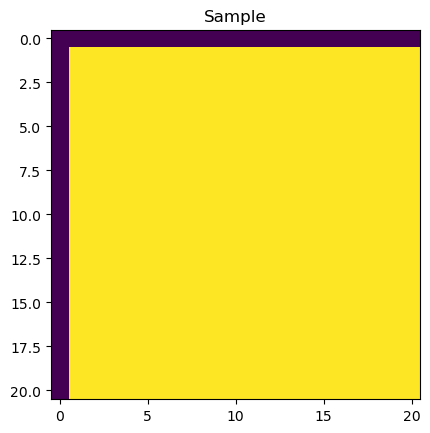

In [44]:
np.max(blank)

0.5

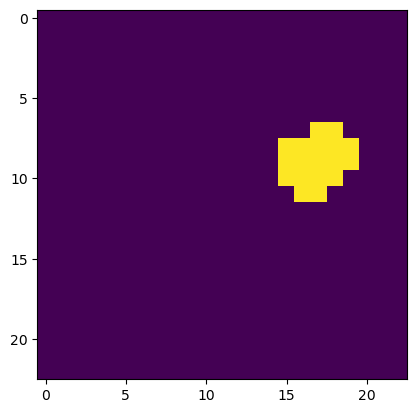

In [ ]:
margin = 3
shape_im = test_im.shape
new_im = np.zeros(shape=(shape_im[0]+margin, shape_im[1]+margin))
new_im[margin:, margin:] = test_im
plt.imshow(new_im)

In [ ]:
idx = np.arange(margin,new_im.shape[0])
positional = True

X_list = []
y_list = []

for i in idx:
    for j in idx:
        
        x = new_im[i-margin:i+1, j-margin:j+1].flatten()
        y = x[-1]
        x = x[:-1]
        if positional:
            ax_y = (i-margin)/idx.shape[0]
            ax_x = (j-margin)/idx.shape[0]            
            x = np.append(x, [ax_x, ax_y])
        
        X_list.append(x)
        y_list.append(y)

X_list = np.array(X_list)
y_list = np.array(y_list)

print(X_list.shape)
print(y_list.shape)

(400, 17)
(400,)


In [ ]:
a,b = image_to_xy(test_dir, 2)
a.shape

C:\Users\HAMI-PARS\AppData\Local\Temp\ipykernel_1964\2171434557.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)


(400, 10)

In [ ]:
def train_model(model, train_loader, val_loader=None, n_jobs=None, epochs=5):
    EPOCHS = epochs
    if n_jobs:
        torch.set_num_threads(n_jobs) # Set number of core to be engaged

    # criterion = nn.NLLLoss()
    criterion = SingleNLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss_list = []
    train_iteration_loss_list = []
    val_loss_list = []

    try:
        for epoch in range(EPOCHS):
            model.train()
            
            t_loss = 0 
            # Train loop
            train_iter = iter(train_loader)
            pbar = trange(len(train_iter),desc=f'Epoch {epoch+1}/{EPOCHS}')
            for i in pbar:
                X_batch, y_batch = next(train_iter)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_hat = model(X_batch)
                loss = criterion(y_batch_hat, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                t_loss += loss.item()
                train_iteration_loss_list.append(t_loss)
                pbar.set_postfix_str(f'train loss:{t_loss/(i+1):.4f}')

            t_loss *= 1/len(train_loader)
            train_loss_list.append(t_loss)

            if val_loader:
                # Validation
                model.eval()

                with torch.no_grad():
                    v_loss = 0
                    for batch in val_loader:
                        X_val, y_val = batch
                        X_val = X_val.to(device)
                        y_val = y_val.to(device)

                        y_val_hat = model(X_val)
                        loss = criterion(y_val_hat, y_val)
                        v_loss += loss.item()
                    val_loss_list.append(v_loss/len(val_loader))
                print(f'validation loss:{val_loss_list[-1]:.4f}')

        return train_loss_list, val_loss_list, train_iteration_loss_list
    except KeyboardInterrupt:
        print('\n\n!!!!!!!! Training has been stopped !!!!!!!!')
        return train_loss_list, val_loss_list, train_iteration_loss_list



history = train_model(single_layer_model, train_loader, val_loader, epochs=4)



Epoch 1/4:  39%|███▉      | 99/255 [00:05<00:08, 18.93it/s, train loss:1.0476]




!!!!!!!! Training has been stopped !!!!!!!!
